In [90]:

import h5py
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", None)
DATA_PATH = Path("p044036.mat")
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)


In [91]:

with h5py.File(DATA_PATH, "r") as f:
    subj_group = f["Subj_Wins"]
    group_keys = sorted(subj_group.keys())

print(f"Subj_Wins columns: {len(group_keys)}")
print(group_keys[:12])


Subj_Wins columns: 28
['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F']


In [92]:

def _resolve_ref(file: h5py.File, ref) -> object:
    value = file[ref][()]
    array = np.array(value)

    if array.dtype.kind in {"S", "U"}:
        flat = array.ravel().astype(str)
        return "".join(flat)

    array = np.squeeze(array)

    if isinstance(array, np.ndarray) and array.dtype.kind in {"i", "u"} and array.size > 1:
        return "".join(chr(int(x)) for x in array)

    if isinstance(array, np.ndarray) and array.size == 1:
        return array.item()

    return array


def extract_scalar_table(h5_path: Path, columns: list[str]) -> pd.DataFrame:
    records: dict[str, list] = {col: [] for col in columns}
    with h5py.File(h5_path, "r") as f:
        subject_group = f["Subj_Wins"]
        for col in columns:
            ds = subject_group[col]
            row = ds[0] if ds.ndim > 1 else ds[:]
            for ref in row:
                records[col].append(_resolve_ref(f, ref))
    return pd.DataFrame(records)


scalar_columns = [
    "SubjectID",
    "SegmentID",
    "WinID",
    "WinSeqID",
    "Age",
    "Gender",
    "IncludeFlag",
    "PPG_ABP_Corr",
    "SegSBP",
    "SegDBP",
]
scalar_df = extract_scalar_table(DATA_PATH, scalar_columns)
scalar_df.head()


,SubjectID,SegmentID,WinID,WinSeqID,Age,Gender,IncludeFlag,PPG_ABP_Corr,SegSBP,SegDBP
0,p044036,285.0,285.0,285.0,54.0,70,1,0.904490,125.542373,66.147942
1,p044036,295.0,295.0,295.0,54.0,70,1,0.901335,124.780405,65.793008
2,p044036,297.0,297.0,297.0,54.0,70,1,0.901462,123.412770,65.102678
3,p044036,309.0,309.0,309.0,54.0,70,1,0.906825,123.403001,65.382718
4,p044036,313.0,313.0,313.0,54.0,70,1,0.906136,123.777473,65.379462


In [93]:

numeric_cols = ["Age", "PPG_ABP_Corr", "SegSBP", "SegDBP"]
for col in numeric_cols:
    scalar_df[col] = pd.to_numeric(scalar_df[col], errors="coerce")

for col in ["SegmentID", "WinID", "WinSeqID", "Gender", "IncludeFlag"]:
    scalar_df[col] = pd.to_numeric(scalar_df[col], errors="coerce").astype("Int64")

scalar_df["SubjectID"] = scalar_df["SubjectID"].astype(str)

print(f"Rows loaded: {len(scalar_df)}")
scalar_df.describe(include="all").T


Rows loaded: 1696


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SubjectID,1696,1,p044036,1696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SegmentID,1696.0,<NA>,<NA>,<NA>,2488.54717,726.108836,285.0,1771.75,2645.5,3110.25,3599.0
WinID,1696.0,<NA>,<NA>,<NA>,2488.54717,726.108836,285.0,1771.75,2645.5,3110.25,3599.0
WinSeqID,1696.0,<NA>,<NA>,<NA>,2488.54717,726.108836,285.0,1771.75,2645.5,3110.25,3599.0
Age,1696.0,NaN,NaN,NaN,54.0,0.0,54.0,54.0,54.0,54.0,54.0
Gender,1696.0,<NA>,<NA>,<NA>,70.0,0.0,70.0,70.0,70.0,70.0,70.0
IncludeFlag,1696.0,<NA>,<NA>,<NA>,1.0,0.0,1.0,1.0,1.0,1.0,1.0
PPG_ABP_Corr,1696.0,NaN,NaN,NaN,0.935309,0.021353,0.900044,0.917734,0.931993,0.952972,0.98104
SegSBP,1696.0,NaN,NaN,NaN,114.1506,5.786264,96.941592,109.730897,114.145415,118.730423,126.805807
SegDBP,1696.0,NaN,NaN,NaN,65.835867,2.772884,55.989299,63.749406,65.964661,67.513658,73.45502


In [94]:

missing_summary = scalar_df.isna().sum().to_frame(name="missing")
missing_summary["pct"] = (missing_summary["missing"] / len(scalar_df)) * 100
missing_summary


,missing,pct
SubjectID,0,0.0
SegmentID,0,0.0
WinID,0,0.0
WinSeqID,0,0.0
Age,0,0.0
Gender,0,0.0
IncludeFlag,0,0.0
PPG_ABP_Corr,0,0.0
SegSBP,0,0.0
SegDBP,0,0.0


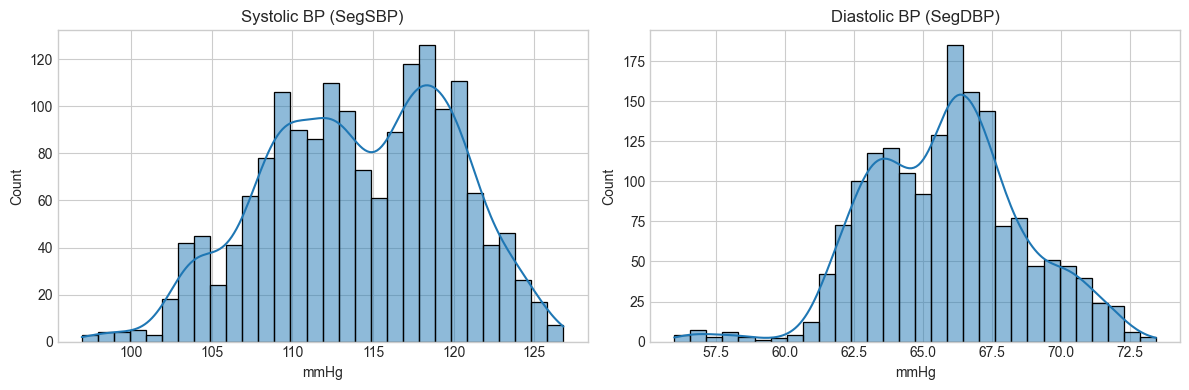

In [95]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(scalar_df["SegSBP"].dropna(), kde=True, bins=30, ax=axes[0])
axes[0].set_title("Systolic BP (SegSBP)")
axes[0].set_xlabel("mmHg")

sns.histplot(scalar_df["SegDBP"].dropna(), kde=True, bins=30, ax=axes[1])
axes[1].set_title("Diastolic BP (SegDBP)")
axes[1].set_xlabel("mmHg")

plt.tight_layout()
plt.show()


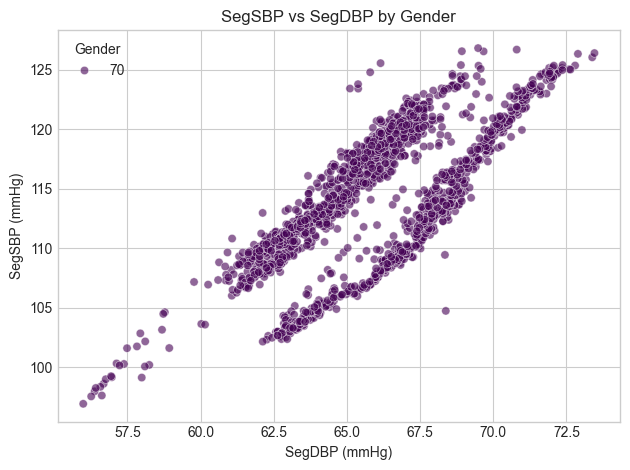

In [96]:

sns.scatterplot(
    data=scalar_df,
    x="SegDBP",
    y="SegSBP",
    hue="Gender",
    palette="viridis",
    alpha=0.6,
)
plt.title("SegSBP vs SegDBP by Gender")
plt.xlabel("SegDBP (mmHg)")
plt.ylabel("SegSBP (mmHg)")
plt.legend(title="Gender", loc="best")
plt.tight_layout()
plt.show()


In [97]:

wave_keys = ["PPG_Raw", "ECG_Raw", "ABP_Raw"]
wave_missing = []
with h5py.File(DATA_PATH, "r") as f:
    grp = f["Subj_Wins"]
    for key in wave_keys:
        total = 0
        nan_count = 0
        for ref in grp[key][0]:
            arr = np.array(f[ref][()], dtype=float).ravel()
            total += arr.size
            nan_count += np.isnan(arr).sum()
        wave_missing.append({
            "signal": key,
            "nan_points": int(nan_count),
            "total_points": int(total),
        })

wave_df = pd.DataFrame(wave_missing)
wave_df["pct_nan"] = wave_df["nan_points"] / wave_df["total_points"] * 100
wave_df


,signal,nan_points,total_points,pct_nan
0,PPG_Raw,0,2120000,0.0
1,ECG_Raw,0,2120000,0.0
2,ABP_Raw,0,2120000,0.0


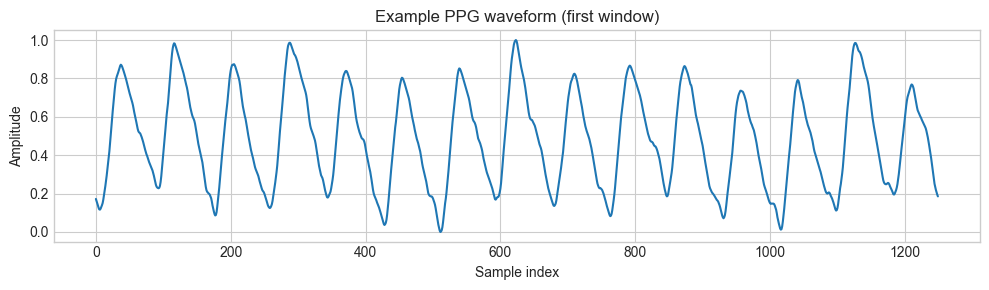

In [98]:

with h5py.File(DATA_PATH, "r") as f:
    first_ref = f["Subj_Wins"]["PPG_Raw"][0][0]
    ppg_first = np.array(f[first_ref][()]).ravel()

plt.figure(figsize=(10, 3))
plt.plot(ppg_first)
plt.title("Example PPG waveform (first window)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


## Waveform 준비 및 타깃 정렬

In [99]:

from typing import List
import numpy as np
import math


def extract_waveform_matrix(h5_path: Path, key: str) -> np.ndarray:
    """Return waveform matrix (segments, samples) for a given signal key."""
    arrays: List[np.ndarray] = []
    with h5py.File(h5_path, "r") as f:
        ds = f["Subj_Wins"][key][0]
        for ref in ds:
            waveform = np.array(f[ref][()], dtype=np.float32).ravel()
            arrays.append(waveform)
    lengths = {arr.shape[0] for arr in arrays}
    if len(lengths) != 1:
        raise ValueError(f"Waveforms have inconsistent lengths for {key}: {lengths}")
    return np.stack(arrays)


ppg_matrix = extract_waveform_matrix(DATA_PATH, "PPG_Raw")
ecg_matrix = extract_waveform_matrix(DATA_PATH, "ECG_Raw")

bp_targets = scalar_df[["SegSBP", "SegDBP"]].to_numpy(dtype=np.float32)
include_flags = scalar_df["IncludeFlag"].fillna(0).to_numpy()
quality_mask = include_flags == 1

ppg_matrix = ppg_matrix[quality_mask]
ecg_matrix = ecg_matrix[quality_mask]
bp_targets = bp_targets[quality_mask]
subject_ids = scalar_df.loc[quality_mask, "SubjectID"].reset_index(drop=True)

usable_segments = (ppg_matrix.shape[0] // 400) * 400
if usable_segments < 400:
    raise RuntimeError("Not enough quality segments to form sequential folds.")

ppg_matrix = ppg_matrix[:usable_segments]
ecg_matrix = ecg_matrix[:usable_segments]
bp_targets = bp_targets[:usable_segments]
subject_ids = subject_ids.iloc[:usable_segments]

SEGMENT_COUNT = ppg_matrix.shape[0]
WINDOW_LENGTH = ppg_matrix.shape[1]
print(f"Usable segments: {SEGMENT_COUNT}, window length: {WINDOW_LENGTH}")
print(subject_ids.head())


Usable segments: 1600, window length: 1250
0    p044036
1    p044036
2    p044036
3    p044036
4    p044036
Name: SubjectID, dtype: object


## 모델 학습 설정

In [100]:

USE_PPG_ONLY = True  # 조건 2: PPG 신호만 사용

if USE_PPG_ONLY:
    feature_data = np.expand_dims(ppg_matrix, axis=1)  # (N, 1, L)
else:
    feature_data = np.stack([ppg_matrix, ecg_matrix], axis=1)  # (N, 2, L)

bp_targets = bp_targets.astype(np.float32)

FOLD_SIZE = 400
TRAIN_VAL_SIZE = 300
VAL_SIZE = 60
TEST_SIZE = FOLD_SIZE - TRAIN_VAL_SIZE
NUM_FOLDS = 4
TRAIN_SIZE = TRAIN_VAL_SIZE - VAL_SIZE

assert TEST_SIZE == 100, "Fold configuration must yield 100 test segments."
assert SEGMENT_COUNT >= NUM_FOLDS * FOLD_SIZE, "Not enough segments for configured folds."

print(f"Feature tensor shape: {feature_data.shape}")
print(f"Targets shape: {bp_targets.shape}")


Feature tensor shape: (1600, 1, 1250)
Targets shape: (1600, 2)


## PyTorch 데이터셋 및 모델

In [101]:

import copy
from dataclasses import dataclass
from typing import Dict, Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(42)
np.random.seed(42)


def normalize_waveforms(data: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    normed = data.copy()
    for c in range(data.shape[1]):
        normed[:, c, :] = (normed[:, c, :] - mean[c]) / std[c]
    return normed


class WaveformDataset(Dataset):
    def __init__(self, inputs: np.ndarray, targets: np.ndarray) -> None:
        self.inputs = torch.from_numpy(inputs.astype(np.float32))
        self.targets = torch.from_numpy(targets.astype(np.float32))

    def __len__(self) -> int:
        return self.inputs.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.inputs[idx], self.targets[idx]


class BPRegressor(nn.Module):
    def __init__(self, in_channels: int) -> None:
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        return self.regressor(features)


def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion, device: torch.device) -> float:
    model.train()
    total_loss = 0.0
    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    return total_loss / len(loader.dataset)


def collect_predictions(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds_list.append(outputs.cpu().numpy())
            targets_list.append(targets.numpy())
    return np.concatenate(preds_list, axis=0), np.concatenate(targets_list, axis=0)


def compute_regression_metrics(preds: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    diff = preds - targets
    mse = np.mean(diff ** 2, axis=0)
    mae = np.mean(np.abs(diff), axis=0)
    return {
        "mse_sbp": float(mse[0]),
        "mse_dbp": float(mse[1]),
        "mse_mean": float(mse.mean()),
        "mae_sbp": float(mae[0]),
        "mae_dbp": float(mae[1]),
        "mae_mean": float(mae.mean()),
    }


def evaluate(model: nn.Module, loader: DataLoader, criterion, device: torch.device) -> Tuple[float, Dict[str, float]]:
    preds, targets = collect_predictions(model, loader, device)
    loss = criterion(torch.from_numpy(preds), torch.from_numpy(targets)).item()
    metrics = compute_regression_metrics(preds, targets)
    return loss, metrics


## 순차 4-Fold 학습 및 평가

In [102]:

BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

fold_results = []
history_frames = []

for fold in range(NUM_FOLDS):
    start = fold * FOLD_SIZE
    train_start = start
    val_start = start + TRAIN_SIZE
    train_end = start + TRAIN_VAL_SIZE
    test_end = start + FOLD_SIZE

    train_idx = np.arange(train_start, val_start)
    val_idx = np.arange(val_start, train_end)
    test_idx = np.arange(train_end, test_end)

    train_inputs = feature_data[train_idx]
    mean = train_inputs.mean(axis=(0, 2))
    std = train_inputs.std(axis=(0, 2))
    std[std < 1e-6] = 1e-6

    train_inputs_norm = normalize_waveforms(train_inputs, mean, std)
    val_inputs_norm = normalize_waveforms(feature_data[val_idx], mean, std)
    test_inputs_norm = normalize_waveforms(feature_data[test_idx], mean, std)

    train_dataset = WaveformDataset(train_inputs_norm, bp_targets[train_idx])
    val_dataset = WaveformDataset(val_inputs_norm, bp_targets[val_idx])
    test_dataset = WaveformDataset(test_inputs_norm, bp_targets[test_idx])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = BPRegressor(feature_data.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    best_state = copy.deepcopy(model.state_dict())
    best_val = float("inf")
    history_rows = []

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device)

        history_rows.append({
            "fold": fold + 1,
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_mse_mean": val_metrics["mse_mean"],
            "val_mae_mean": val_metrics["mae_mean"],
            "val_mae_sbp": val_metrics["mae_sbp"],
            "val_mae_dbp": val_metrics["mae_dbp"],
        })

        if val_metrics["mse_mean"] < best_val:
            best_val = val_metrics["mse_mean"]
            best_state = copy.deepcopy(model.state_dict())

        if epoch == 1 or epoch % 5 == 0 or epoch == EPOCHS:
            print(
                f"Fold {fold + 1} | Epoch {epoch:02d} | "
                f"train_loss={train_loss:.4f} val_mse={val_metrics['mse_mean']:.4f} "
                f"val_mae_sbp={val_metrics['mae_sbp']:.3f} val_mae_dbp={val_metrics['mae_dbp']:.3f}"
            )

    model.load_state_dict(best_state)
    test_loss, test_metrics = evaluate(model, test_loader, criterion, device)

    fold_results.append({
        "fold": fold + 1,
        **test_metrics,
    })

    history_frames.append(pd.DataFrame(history_rows))

    print(
        f"Fold {fold + 1} Test -> MSE(SBP)={test_metrics['mse_sbp']:.4f}, "
        f"MSE(DBP)={test_metrics['mse_dbp']:.4f}, MAE(SBP)={test_metrics['mae_sbp']:.3f}, "
        f"MAE(DBP)={test_metrics['mae_dbp']:.3f}"
    )

fold_history_df = pd.concat(history_frames, ignore_index=True)
fold_summary_df = pd.DataFrame(fold_results)

mean_metrics = fold_summary_df.mean(numeric_only=True)
print("\nAverage metrics across folds:")
print(mean_metrics)

fold_summary_df


Using device: cpu
Fold 1 | Epoch 01 | train_loss=8522.8038 val_mse=8782.5215 val_mae_sbp=113.684 val_mae_dbp=68.111
Fold 1 | Epoch 05 | train_loss=7917.7490 val_mse=8064.7920 val_mae_sbp=109.656 val_mae_dbp=64.057
Fold 1 | Epoch 10 | train_loss=6626.6262 val_mse=6696.3691 val_mae_sbp=101.333 val_mae_dbp=55.879
Fold 1 | Epoch 15 | train_loss=4840.4797 val_mse=4699.2476 val_mae_sbp=87.216 val_mae_dbp=42.308
Fold 1 | Epoch 20 | train_loss=2761.2514 val_mse=2548.4531 val_mae_sbp=67.169 val_mae_dbp=24.148
Fold 1 | Epoch 25 | train_loss=1009.0645 val_mse=971.7891 val_mae_sbp=43.595 val_mae_dbp=6.406
Fold 1 | Epoch 30 | train_loss=239.1523 val_mse=223.8994 val_mae_sbp=20.726 val_mae_dbp=2.224
Fold 1 | Epoch 35 | train_loss=143.2056 val_mse=12.9695 val_mae_sbp=4.128 val_mae_dbp=2.030
Fold 1 | Epoch 40 | train_loss=135.1331 val_mse=11.6070 val_mae_sbp=3.993 val_mae_dbp=1.973
Fold 1 Test -> MSE(SBP)=10.3024, MSE(DBP)=2.5047, MAE(SBP)=2.542, MAE(DBP)=1.289
Fold 2 | Epoch 01 | train_loss=8514.2878

,fold,mse_sbp,mse_dbp,mse_mean,mae_sbp,mae_dbp,mae_mean
0,1,10.302413,2.504680,6.403546,2.542065,1.289344,1.915704
1,2,67.056061,29.759466,48.407764,7.056344,4.233450,5.644897
2,3,2.568550,3.249095,2.908823,1.320685,1.645509,1.483097
3,4,14.735442,4.430948,9.583195,3.605188,1.936362,2.770775
